**Fashion MNIST MLP implementation from scratch**



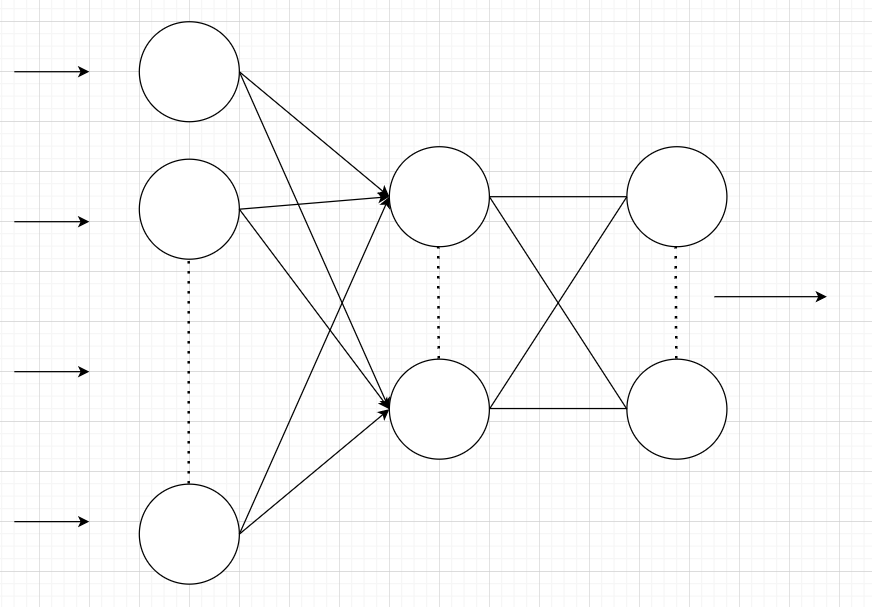

**Network Architecture:**

Input layer: 784 neurons

*   784 neurons
*   sigmoid/ ReLU activation


Hidden layer(x1):

*   10 neurons
*   sigmoid/ ReLU activation


Output layer:

*   10 neurons
*   softmax activation

**Hyperparameter selection**
1. ReLU activation function
*   learning rate = 0.5
*   epochs = 1000


2. Sigmoid activation function
*   learning rate = 0.75
*   epochs = 1000

# Modules imported

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
from math import log
import random
import pickle

# Data loading from Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_test = "/content/drive/MyDrive/Datasets/MNIST/fashion-mnist_test.csv"
test_data = pd.read_csv(path_test)

In [ ]:
path_train = "/content/drive/MyDrive/Datasets/MNIST/fashion-mnist_train.csv"
train_data = pd.read_csv(path_train)

# Data visualization

In [ ]:
vis_test_labels = np.array(test_data.loc[:,'label'])
vis_test_data = np.array(test_data.loc[:,test_data.columns!='label'])

In [ ]:
vis_train_labels = np.array(train_data.loc[:,'label'])
vis_train_data = np.array(train_data.loc[:,train_data.columns!='label'])

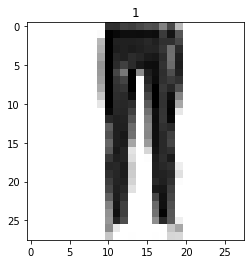

In [ ]:
object = random.randint(0, 9999)
plt.title((vis_test_labels[object]))
plt.imshow(vis_test_data[object].reshape(28,28), cmap=cm.binary)

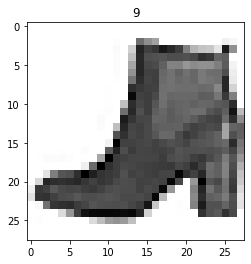

In [ ]:
object = random.randint(0, 59999)
plt.title((vis_train_labels[object]))
plt.imshow(vis_train_data[object].reshape(28,28), cmap=cm.binary)

# Data preprocessing

In [ ]:
def prepare_test_data(test_data):
  test_data = np.array(test_data)
  m,n = np.shape(test_data)
  print(m,n)
  np.random.shuffle(test_data)

  test_data = test_data[0:m].T
  Y_test = test_data[0]
  X_test = test_data[1:n]
  X_test = X_test / 255.
  _,m_test = X_test.shape

  return (Y_test, X_test)

Y_test, X_test = prepare_test_data(test_data)

10000 785


In [ ]:
def prepare_train_data(train_data):
  train_data = np.array(train_data)
  m,n = np.shape(train_data)
  print(m,n)

  np.random.shuffle(train_data)

  train_data = train_data[0:m].T
  Y_train = train_data[0]
  X_train = train_data[1:n]
  X_train = X_train / 255.
  _,m_train = X_train.shape
  return (Y_train, X_train)

Y_train, X_train = prepare_train_data(train_data)

60000 785


# ReLU with Zero weight initialization

## Activation functions

In [ ]:
def ReLU(Z):
    return np.maximum(Z, 0)

In [ ]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [ ]:
def ReLU_deriv(Z):
    return Z > 0

## Weight and Bias initialization

In [ ]:
def init_params_zeros():
    W1 = np.array([[0 for i in range(784)] for x in range(10)])
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.array([[0 for i in range(10)] for x in range(10)])
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

## Forward propogation

In [ ]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

## Backward propogation

In [ ]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m, n = np.shape(train_data)
    one_hot_encoder_Y = one_hot_encoder(Y)
    dZ2 = A2 - one_hot_encoder_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

## Helper functions

In [ ]:
def one_hot_encoder(Y):
    one_hot_encoder_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_encoder_Y[np.arange(Y.size), Y] = 1
    one_hot_encoder_Y = one_hot_encoder_Y.T
    return one_hot_encoder_Y

In [ ]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1    
    W2 = W2 - learning_rate * dW2  
    b2 = b2 - learning_rate * db2    
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [ ]:
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [ ]:
def get_loss(predictions, Y):
    predictions = np.add(predictions, [1 for x in predictions])
    Y = np.add(Y, [1 for x in range(Y.shape[-1])])
    predictions = np.multiply(predictions, [0.1 for x in predictions])
    Y = np.multiply(Y, [0.1 for x in range(Y.shape[-1])])
    loss = abs(-sum([Y[i]*log(predictions[i]) for i in range(len(Y))]))
    return loss/len(Y)

## Main function for MLP

In [ ]:
training_accuracy = []
validation_accuracy = []

training_loss = []
validation_loss = []

In [ ]:
def train_mlp_model_relu_zero(X, Y, learning_rate, epochs):
    print("Training MLP model")
    W1, b1, W2, b2 = init_params_zeros()
    for i in range(epochs+1):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 10 == 0:
            print("Epochs: ", i)
            predictions = get_predictions(A2)
            training_accuracy.append(get_accuracy(predictions, Y)*100)
            training_loss.append(get_loss(predictions, Y)*100)

            print("Accuracy: " + str(training_accuracy[-1]))
            print("Loss: " + str(training_loss[-1]))

    return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = train_mlp_model_relu_zero(X_train, Y_train, 0.50, 1000)

Training MLP model
Epochs:  0
[1 1 1 ... 1 1 1] [2 4 3 ... 1 5 3]
Accuracy: 10.0
Loss: 88.51908518386875
Epochs:  10
[9 9 1 ... 1 9 4] [2 4 3 ... 1 5 3]
Accuracy: 21.208333333333336
Loss: 13.67515584819318
Epochs:  20
[4 1 1 ... 1 9 1] [2 4 3 ... 1 5 3]
Accuracy: 26.81833333333333
Loss: 25.568348934703227
Epochs:  30
[8 4 4 ... 4 9 4] [2 4 3 ... 1 5 3]
Accuracy: 18.955
Loss: 11.247742228844
Epochs:  40
[4 4 4 ... 4 9 4] [2 4 3 ... 1 5 3]
Accuracy: 20.118333333333332
Loss: 23.051512874851955
Epochs:  50
[4 4 1 ... 4 7 4] [2 4 3 ... 1 5 3]
Accuracy: 25.44
Loss: 28.102696563665404
Epochs:  60
[4 4 1 ... 1 5 4] [2 4 3 ... 1 5 3]
Accuracy: 38.571666666666665
Loss: 26.781601234605308
Epochs:  70
[4 4 1 ... 1 5 4] [2 4 3 ... 1 5 3]
Accuracy: 41.33166666666666
Loss: 29.219610598822754
Epochs:  80
[2 4 1 ... 1 5 4] [2 4 3 ... 1 5 3]
Accuracy: 49.655
Loss: 30.639647211972697
Epochs:  90
[2 2 1 ... 1 5 0] [2 4 3 ... 1 5 3]
Accuracy: 53.28666666666667
Loss: 39.96239746002212
Epochs:  100
[2 6 1 ..

In [ ]:
Model_1 = (W1, b1, W2, b2)
print(Model_1)

(array([[-5.24063591e-05,  7.60584263e-05, -5.39798363e-04, ...,
        -5.39296715e-03, -8.26118998e-04, -1.31600597e-04],
       [ 1.92545248e-04,  1.29165913e-04,  2.34063896e-04, ...,
        -1.24507229e-02, -6.49823044e-03, -1.65236138e-03],
       [ 3.44045238e-05,  3.13567592e-04,  4.35828618e-04, ...,
        -4.45893417e-02, -1.23161962e-02, -1.88733505e-03],
       ...,
       [-1.19201418e-04, -1.43108308e-04, -1.13183129e-03, ...,
        -9.32647547e-03, -1.40534624e-03, -9.44258155e-04],
       [ 9.11708785e-05,  5.76550078e-05, -7.76153463e-04, ...,
        -1.81145034e-03, -6.06745518e-04,  2.69409989e-04],
       [-1.39354278e-06,  5.71432725e-05,  1.01965034e-03, ...,
        -1.21867685e-03,  2.86736124e-03, -7.19058083e-04]]), array([[2.02162718],
       [1.70255077],
       [1.60320755],
       [2.28175106],
       [2.04207388],
       [1.6806305 ],
       [2.23528021],
       [1.72578155],
       [1.76195139],
       [2.22992408]]), array([[ 0.99252789,  0.12385

In [ ]:
def valid_mlp_model(Y_test, X_test, W1, b1, W2, b2, epochs):
  print("Validating MLP model")
  for i in range(epochs+1):
    if i % 10 == 0:
      index = random.randint(0, 7999)
      X_valid = np.array([(X_test[i][index: index+2000]) for i in range(784)])
      Y_valid = np.array(Y_test[index: index+2000])
      print("Epochs: ", i)
      test_predictions = make_predictions(X_valid, W1, b1, W2, b2)
      validation_accuracy.append(get_accuracy(test_predictions, Y_valid)*100)
      print("Accuracy: " + str(validation_accuracy[-1]))
      validation_loss.append(get_loss(test_predictions, Y_valid)*100)
      print("Loss: " + str(validation_loss[-1]))

In [ ]:
valid_mlp_model(Y_test, X_test, W1, b1, W2, b2, 1000)

Validating MLP model
Epochs:  0
[6 0 8 ... 2 7 5] [6 0 8 ... 2 7 5]
Accuracy: 84.5
Loss: 26.624980246269107
Epochs:  10
[5 2 9 ... 5 8 1] [5 2 9 ... 5 8 1]
Accuracy: 85.1
Loss: 26.776529949446775
Epochs:  20
[8 6 1 ... 6 5 1] [8 2 1 ... 6 5 1]
Accuracy: 84.6
Loss: 26.585432020563022
Epochs:  30
[8 1 5 ... 3 2 6] [8 1 5 ... 2 2 6]
Accuracy: 84.55
Loss: 26.757841995047883
Epochs:  40
[4 0 3 ... 1 8 9] [4 0 3 ... 1 8 9]
Accuracy: 83.85000000000001
Loss: 26.126991175739622
Epochs:  50
[8 4 7 ... 8 4 7] [8 8 7 ... 8 4 7]
Accuracy: 84.7
Loss: 26.663187496565303
Epochs:  60
[2 1 8 ... 8 8 5] [2 1 8 ... 8 8 5]
Accuracy: 84.45
Loss: 26.5732496065533
Epochs:  70
[9 8 4 ... 1 6 9] [9 8 4 ... 1 8 9]
Accuracy: 82.85
Loss: 26.364367768651135
Epochs:  80
[9 0 8 ... 2 9 9] [9 0 8 ... 2 9 9]
Accuracy: 86.05000000000001
Loss: 26.599951329408007
Epochs:  90
[3 6 2 ... 4 8 0] [3 6 2 ... 4 8 0]
Accuracy: 84.05
Loss: 26.547103363329143
Epochs:  100
[3 3 8 ... 2 9 0] [3 3 8 ... 2 9 0]
Accuracy: 84.2
Loss: 26

## Graph Plots

In [ ]:
def plot_graph(train, valid, s):
    x_value = [i*10 for i in range(len(train))]
    plt.xlabel('Epochs')
    plt.ylabel(s)
    plt.plot(x_value,train,0.,color='b', label="Training "+s)
    plt.plot(x_value,valid,0.,color='r', label="Validation "+s)
    plt.legend()

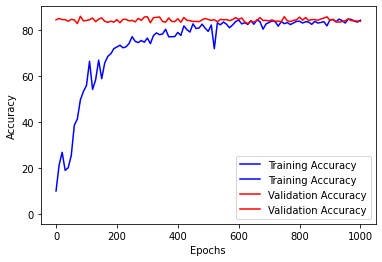

In [ ]:
plot_graph(training_accuracy, validation_accuracy, "Accuracy")

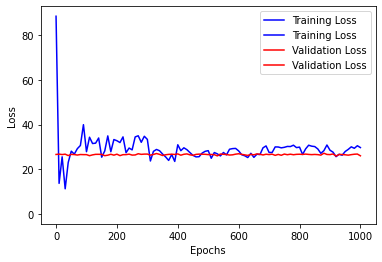

In [ ]:
plot_graph(training_loss, validation_loss, "Loss")

# ReLU with random Normal weight initialization

## Activation function

In [ ]:
def ReLU(Z):
    return np.maximum(Z, 0)

In [ ]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [ ]:
def ReLU_deriv(Z):
    return Z > 0

## Weight and Bias initialization

In [ ]:
def init_params_random_normal():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

## Forward propogation

In [ ]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

## Backward propogation

In [ ]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m, n = np.shape(train_data)
    one_hot_encoder_Y = one_hot_encoder(Y)
    dZ2 = A2 - one_hot_encoder_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

## Helper function

In [ ]:
def one_hot_encoder(Y):
    one_hot_encoder_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_encoder_Y[np.arange(Y.size), Y] = 1
    one_hot_encoder_Y = one_hot_encoder_Y.T
    return one_hot_encoder_Y

In [ ]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1    
    W2 = W2 - learning_rate * dW2  
    b2 = b2 - learning_rate * db2    
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [ ]:
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [ ]:
def get_loss(predictions, Y):
    predictions = np.add(predictions, [1 for x in predictions])
    Y = np.add(Y, [1 for x in range(Y.shape[-1])])
    predictions = np.multiply(predictions, [0.1 for x in predictions])
    Y = np.multiply(Y, [0.1 for x in range(Y.shape[-1])])
    loss = abs(-sum([Y[i]*log(predictions[i]) for i in range(len(Y))]))
    return loss/len(Y)

## Main function for MLP

In [ ]:
training_accuracy = []
validation_accuracy = []

training_loss = []
validation_loss = []

In [ ]:
def train_mlp_model_relu_normal(X, Y, learning_rate, epochs):
    print("Training MLP model")
    W1, b1, W2, b2 = init_params_zeros()
    for i in range(epochs+1):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 10 == 0:
            print("Epochs: ", i)
            predictions = get_predictions(A2)
            training_accuracy.append(get_accuracy(predictions, Y)*100)
            training_loss.append(get_loss(predictions, Y)*100)

            print("Accuracy: " + str(training_accuracy[-1]))
            print("Loss: " + str(training_loss[-1]))

    return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = train_mlp_model_relu_normal(X_train, Y_train, 0.50, 1000)

Training MLP model
Epochs:  0
[5 5 5 ... 5 5 5] [2 4 3 ... 1 5 3]
Accuracy: 10.0
Loss: 28.095409307123365
Epochs:  10
[9 9 6 ... 6 9 6] [2 4 3 ... 1 5 3]
Accuracy: 13.826666666666668
Loss: 7.89447174983064
Epochs:  20
[5 5 5 ... 5 9 5] [2 4 3 ... 1 5 3]
Accuracy: 11.971666666666666
Loss: 14.015096951249328
Epochs:  30
[5 5 5 ... 5 7 5] [2 4 3 ... 1 5 3]
Accuracy: 12.245000000000001
Loss: 19.746109326144097
Epochs:  40
[4 4 4 ... 4 7 4] [2 4 3 ... 1 5 3]
Accuracy: 27.47833333333333
Loss: 21.51177452354764
Epochs:  50
[4 4 4 ... 4 7 4] [2 4 3 ... 1 5 3]
Accuracy: 22.113333333333333
Loss: 27.27936865347369
Epochs:  60
[0 0 0 ... 0 5 0] [2 4 3 ... 1 5 3]
Accuracy: 26.645000000000003
Loss: 59.86821612831423
Epochs:  70
[0 0 0 ... 0 9 0] [2 4 3 ... 1 5 3]
Accuracy: 28.286666666666665
Loss: 72.89357945381629
Epochs:  80
[4 4 4 ... 4 9 4] [2 4 3 ... 1 5 3]
Accuracy: 30.615
Loss: 23.567912784840903
Epochs:  90
[2 2 6 ... 4 9 4] [2 4 3 ... 1 5 3]
Accuracy: 29.34
Loss: 28.241768229089686
Epochs: 

In [ ]:
Model_2 = (W1, b1, W2, b2)
print(Model_2)

(array([[-1.66490247e-06, -1.48724564e-04, -2.36389467e-04, ...,
         3.61778936e-02,  1.34610313e-02, -6.58568462e-04],
       [-2.51851030e-06,  3.77156478e-07, -5.83172655e-05, ...,
        -1.43153541e-03,  1.31959880e-04, -9.98082844e-05],
       [-2.01684284e-06,  1.07794450e-04,  6.65226839e-05, ...,
        -5.35926043e-03,  5.79722112e-03,  1.24611034e-03],
       ...,
       [-2.87899075e-05, -1.83769005e-04,  1.50419276e-03, ...,
         8.12910982e-02,  2.29247848e-02,  3.69505141e-03],
       [ 3.09266177e-07, -9.84216775e-06, -3.44472536e-05, ...,
        -1.46319635e-03, -1.09121951e-03, -1.12023225e-04],
       [ 1.88426420e-05,  4.20775195e-07,  5.29310500e-05, ...,
        -4.00861666e-04, -2.08479675e-03, -2.48684310e-05]]), array([[2.1669863 ],
       [2.02143908],
       [2.12268449],
       [2.31547465],
       [2.11908007],
       [1.59538263],
       [1.69681773],
       [1.65374321],
       [1.71526332],
       [1.89738441]]), array([[-0.03858135, -0.22655

In [ ]:
def valid_mlp_model(Y_test, X_test, W1, b1, W2, b2, epochs):
  print("Validating MLP model")
  for i in range(epochs+1):
    if i % 10 == 0:
      index = random.randint(0, 7999)
      X_valid = np.array([(X_test[i][index: index+2000]) for i in range(784)])
      Y_valid = np.array(Y_test[index: index+2000])
      print("Epochs: ", i)
      test_predictions = make_predictions(X_valid, W1, b1, W2, b2)
      validation_accuracy.append(get_accuracy(test_predictions, Y_valid)*100)
      print("Accuracy: " + str(validation_accuracy[-1]))
      validation_loss.append(get_loss(test_predictions, Y_valid)*100)
      print("Loss: " + str(validation_loss[-1]))

In [ ]:
valid_mlp_model(Y_test, X_test, W1, b1, W2, b2, 1000)

Validating MLP model
Epochs:  0
[0 0 9 ... 3 4 7] [0 0 9 ... 3 4 7]
Accuracy: 77.60000000000001
Loss: 29.78860082433185
Epochs:  10
[9 6 8 ... 6 6 3] [9 6 6 ... 2 4 3]
Accuracy: 77.95
Loss: 30.096907795392397
Epochs:  20
[2 6 1 ... 3 8 2] [2 6 1 ... 3 8 2]
Accuracy: 77.8
Loss: 30.451647249339132
Epochs:  30
[9 8 7 ... 7 9 8] [9 8 5 ... 7 9 8]
Accuracy: 77.85
Loss: 29.783356430551482
Epochs:  40
[3 1 6 ... 9 2 5] [3 1 4 ... 9 4 5]
Accuracy: 77.14999999999999
Loss: 30.168724214402964
Epochs:  50
[9 8 3 ... 6 6 7] [9 8 6 ... 2 6 7]
Accuracy: 77.25
Loss: 30.187290016549262
Epochs:  60
[0 7 2 ... 6 0 1] [0 7 4 ... 6 3 1]
Accuracy: 77.05
Loss: 30.29111193102949
Epochs:  70
[6 3 9 ... 3 2 5] [6 3 9 ... 3 6 5]
Accuracy: 77.9
Loss: 30.86466913102268
Epochs:  80
[8 3 8 ... 6 9 1] [8 3 8 ... 6 9 1]
Accuracy: 77.85
Loss: 29.474297859266546
Epochs:  90
[4 6 3 ... 1 8 3] [4 6 4 ... 1 8 3]
Accuracy: 77.55
Loss: 30.04308493490866
Epochs:  100
[3 3 6 ... 1 2 5] [3 3 6 ... 1 2 5]
Accuracy: 76.55
Loss: 3

## Graph Plots

In [ ]:
def plot_graph(train, valid, s):
    x_value = [i*10 for i in range(len(train))]
    plt.xlabel('Epochs')
    plt.ylabel(s)
    plt.plot(x_value,train,0.,color='b', label="Training "+s)
    plt.plot(x_value,valid,0.,color='r', label="Validation "+s)
    plt.legend()

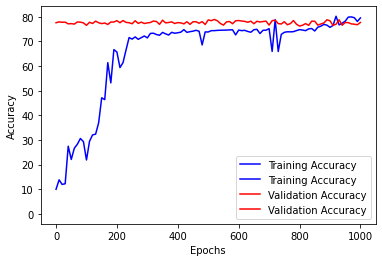

In [ ]:
plot_graph(training_accuracy, validation_accuracy, "Accuracy")

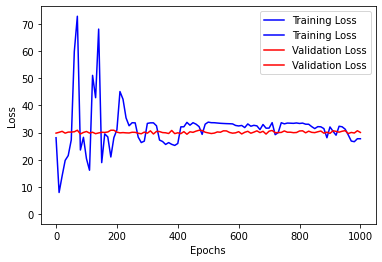

In [ ]:
plot_graph(training_loss, validation_loss, "Loss")

# Sigmoid with Zero weight initialization

## Activation functions

In [ ]:
def Sigmoid(Z):
    return 1.0 / (1.0 + np.exp(-Z))

In [ ]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [ ]:
def Sigmoid_deriv(Z):
  return Sigmoid(Z) * (1- Sigmoid(Z))

## Weight and Bias initialization

In [ ]:
def init_params_zeros():
    W1 = np.array([[0 for i in range(784)] for x in range(10)])
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.array([[0 for i in range(10)] for x in range(10)])
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

## Forward propogation

In [ ]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = Sigmoid(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

## Backward propogation

In [ ]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m, n = np.shape(train_data)
    one_hot_encoder_Y = one_hot_encoder(Y)
    dZ2 = A2 - one_hot_encoder_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * Sigmoid_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

## Helper functions

In [ ]:
def one_hot_encoder(Y):
    one_hot_encoder_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_encoder_Y[np.arange(Y.size), Y] = 1
    one_hot_encoder_Y = one_hot_encoder_Y.T
    return one_hot_encoder_Y

In [ ]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1    
    W2 = W2 - learning_rate * dW2  
    b2 = b2 - learning_rate * db2    
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [ ]:
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [ ]:
def get_loss(predictions, Y):
    predictions = np.add(predictions, [1 for x in predictions])
    Y = np.add(Y, [1 for x in range(Y.shape[-1])])
    predictions = np.multiply(predictions, [0.1 for x in predictions])
    Y = np.multiply(Y, [0.1 for x in range(Y.shape[-1])])
    loss = abs(-sum([Y[i]*log(predictions[i]) for i in range(len(Y))]))
    return loss/len(Y)

## Main function for MLP

In [ ]:
training_accuracy = []
validation_accuracy = []

training_loss = []
validation_loss = []

In [ ]:
def train_mlp_model_sigmoid_zero(X, Y, learning_rate, epochs):
    print("Training MLP model")
    W1, b1, W2, b2 = init_params_zeros()
    for i in range(epochs+1):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 10 == 0:
            print("Epochs: ", i)
            predictions = get_predictions(A2)
            training_accuracy.append(get_accuracy(predictions, Y)*100)
            training_loss.append(get_loss(predictions, Y)*100)

            print("Accuracy: " + str(training_accuracy[-1]))
            print("Loss: " + str(training_loss[-1]))

    return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = train_mlp_model_sigmoid_zero(X_train, Y_train, 0.750, 1000)

Training MLP model
Epochs:  0
[0 0 0 ... 0 0 0] [2 4 3 ... 1 5 3]
Accuracy: 10.0
Loss: 126.64218011465258
Epochs:  10
[4 4 4 ... 4 0 4] [2 4 3 ... 1 5 3]
Accuracy: 11.581666666666667
Loss: 82.0342717491453
Epochs:  20
[4 4 4 ... 4 0 1] [2 4 3 ... 1 5 3]
Accuracy: 9.468333333333332
Loss: 94.87932037226291
Epochs:  30
[1 1 1 ... 1 0 1] [2 4 3 ... 1 5 3]
Accuracy: 10.26
Loss: 111.0848382205851
Epochs:  40
[1 1 1 ... 1 0 1] [2 4 3 ... 1 5 3]
Accuracy: 10.58
Loss: 112.5888520778686
Epochs:  50
[0 1 1 ... 1 0 1] [2 4 3 ... 1 5 3]
Accuracy: 15.384999999999998
Loss: 110.81617465478163
Epochs:  60
[4 4 1 ... 1 0 1] [2 4 3 ... 1 5 3]
Accuracy: 19.178333333333335
Loss: 102.98843568779577
Epochs:  70
[4 4 1 ... 1 0 1] [2 4 3 ... 1 5 3]
Accuracy: 21.753333333333334
Loss: 101.5136717446094
Epochs:  80
[4 4 1 ... 1 0 0] [2 4 3 ... 1 5 3]
Accuracy: 24.723333333333333
Loss: 102.80632906033273
Epochs:  90
[2 4 1 ... 1 0 0] [2 4 3 ... 1 5 3]
Accuracy: 26.61
Loss: 104.8359903383774
Epochs:  100
[2 4 1 ...

In [ ]:
Model_3 = (W1, b1, W2, b2)
print(Model_3)

(array([[ 5.35303411e-05, -8.40408145e-06, -6.53301043e-04, ...,
        -3.06192184e-03, -2.09846846e-03,  7.32037036e-05],
       [ 2.16439513e-06, -1.02139108e-05, -4.96664418e-04, ...,
         2.08846082e-02,  1.14429833e-02, -3.65005018e-04],
       [ 1.09639629e-04, -4.72915043e-05,  5.54101515e-04, ...,
         2.11511743e-02,  8.07749992e-03,  1.21475778e-03],
       ...,
       [ 1.58393376e-04,  2.12513155e-04,  1.71321723e-03, ...,
        -3.35676461e-02, -6.06172855e-03,  2.07759468e-03],
       [ 8.76163282e-05,  2.60462960e-04, -5.29951490e-04, ...,
        -4.14960000e-02, -1.35643490e-02, -1.97197804e-03],
       [-3.89956197e-05, -1.45685445e-04,  2.71734375e-03, ...,
         1.56527525e-02,  6.90451184e-03,  1.97915023e-03]]), array([[1.13101197],
       [1.27475466],
       [0.99098259],
       [0.69379299],
       [1.01726837],
       [0.74285758],
       [1.25180877],
       [1.06256902],
       [1.08145327],
       [0.86802664]]), array([[-1.34500573, -1.88152

In [ ]:
def valid_mlp_model(Y_test, X_test, W1, b1, W2, b2, epochs):
  print("Validating MLP model")
  for i in range(epochs+1):
    if i % 10 == 0:
      index = random.randint(0, 7999)
      X_valid = np.array([(X_test[i][index: index+2000]) for i in range(784)])
      Y_valid = np.array(Y_test[index: index+2000])
      print("Epochs: ", i)
      test_predictions = make_predictions(X_valid, W1, b1, W2, b2)
      validation_accuracy.append(get_accuracy(test_predictions, Y_valid)*100)
      print("Accuracy: " + str(validation_accuracy[-1]))
      validation_loss.append(get_loss(test_predictions, Y_valid)*100)
      print("Loss: " + str(validation_loss[-1]))

In [ ]:
valid_mlp_model(Y_test, X_test, W1, b1, W2, b2, 1000)

Validating MLP model
Epochs:  0
[0 5 4 ... 2 9 9] [6 5 4 ... 6 9 9]
Accuracy: 82.65
Loss: 28.80857579293825
Epochs:  10
[5 4 0 ... 1 6 4] [5 4 0 ... 1 2 4]
Accuracy: 82.55
Loss: 28.026028055990114
Epochs:  20
[3 0 7 ... 4 1 9] [3 0 7 ... 4 1 9]
Accuracy: 82.55
Loss: 29.28329748293878
Epochs:  30
[5 4 6 ... 4 2 4] [5 4 0 ... 4 6 6]
Accuracy: 82.55
Loss: 28.515530830739255
Epochs:  40
[3 6 0 ... 4 9 5] [3 6 6 ... 4 9 5]
Accuracy: 82.45
Loss: 28.443767677688513
Epochs:  50
[1 9 8 ... 6 9 2] [1 9 8 ... 6 9 2]
Accuracy: 83.55
Loss: 28.739910919731273
Epochs:  60
[0 9 6 ... 8 3 1] [0 9 3 ... 0 3 3]
Accuracy: 82.55
Loss: 28.295699029714495
Epochs:  70
[9 5 8 ... 7 2 5] [9 5 8 ... 7 2 5]
Accuracy: 82.69999999999999
Loss: 29.185752949350707
Epochs:  80
[6 5 4 ... 4 5 0] [6 5 4 ... 4 5 0]
Accuracy: 82.39999999999999
Loss: 29.262894391933962
Epochs:  90
[1 5 8 ... 2 8 7] [1 5 8 ... 0 6 9]
Accuracy: 82.65
Loss: 28.292188999929856
Epochs:  100
[5 3 5 ... 9 0 7] [5 3 7 ... 9 0 7]
Accuracy: 82.899999

## Graph Plots

In [ ]:
def plot_graph(train, valid, s):
    x_value = [i*10 for i in range(len(train))]
    plt.xlabel('Epochs')
    plt.ylabel(s)
    plt.plot(x_value,train,0.,color='b', label="Training "+s)
    plt.plot(x_value,valid,0.,color='r', label="Validation "+s)
    plt.legend()

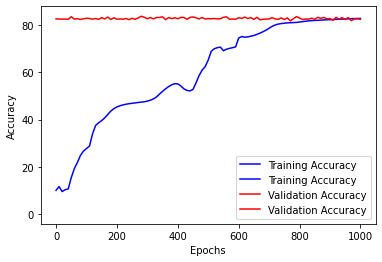

In [ ]:
plot_graph(training_accuracy, validation_accuracy, "Accuracy")

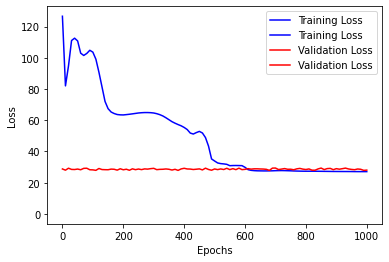

In [ ]:
plot_graph(training_loss, validation_loss, "Loss")

# Sigmoid with random Normal weight initialization

## Activation function

In [ ]:
def Sigmoid(Z):
    return 1.0 / (1.0 + np.exp(-Z))

In [ ]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [ ]:
def Sigmoid_deriv(Z):
  return Sigmoid(Z) * (1- Sigmoid(Z))

## Weight and Bias initialization

In [ ]:
def init_params_random_normal():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

## Forward propogation

In [ ]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = Sigmoid(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

## Backward propogation

In [ ]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m, n = np.shape(train_data)
    one_hot_encoder_Y = one_hot_encoder(Y)
    dZ2 = A2 - one_hot_encoder_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * Sigmoid_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

## Helper functions

In [ ]:
def one_hot_encoder(Y):
    one_hot_encoder_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_encoder_Y[np.arange(Y.size), Y] = 1
    one_hot_encoder_Y = one_hot_encoder_Y.T
    return one_hot_encoder_Y

In [ ]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1    
    W2 = W2 - learning_rate * dW2  
    b2 = b2 - learning_rate * db2    
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [ ]:
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [ ]:
def get_loss(predictions, Y):
    predictions = np.add(predictions, [1 for x in predictions])
    Y = np.add(Y, [1 for x in range(Y.shape[-1])])
    predictions = np.multiply(predictions, [0.1 for x in predictions])
    Y = np.multiply(Y, [0.1 for x in range(Y.shape[-1])])
    loss = abs(-sum([Y[i]*log(predictions[i]) for i in range(len(Y))]))
    return loss/len(Y)

## Main function for MLP

In [ ]:
training_accuracy = []
validation_accuracy = []

training_loss = []
validation_loss = []

In [ ]:
def train_mlp_model_sigmoid_normal(X, Y, learning_rate, epochs):
    print("Training MLP model")
    W1, b1, W2, b2 = init_params_zeros()
    for i in range(epochs+1):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 10 == 0:
            print("Epochs: ", i)
            predictions = get_predictions(A2)
            training_accuracy.append(get_accuracy(predictions, Y)*100)
            training_loss.append(get_loss(predictions, Y)*100)

            print("Accuracy: " + str(training_accuracy[-1]))
            print("Loss: " + str(training_loss[-1]))

    return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = train_mlp_model_sigmoid_normal(X_train, Y_train, 0.50, 1000)

Training MLP model
Epochs:  0
[5 5 5 ... 5 5 5] [2 4 3 ... 1 5 3]
Accuracy: 10.0
Loss: 28.095409307123365
Epochs:  10
[4 4 0 ... 4 0 0] [2 4 3 ... 1 5 3]
Accuracy: 14.226666666666668
Loss: 54.6600736479111
Epochs:  20
[2 2 4 ... 4 4 4] [2 4 3 ... 1 5 3]
Accuracy: 9.42
Loss: 50.4291396201345
Epochs:  30
[2 2 4 ... 4 4 4] [2 4 3 ... 1 5 3]
Accuracy: 9.911666666666667
Loss: 51.48041875384607
Epochs:  40
[2 2 4 ... 4 4 4] [2 4 3 ... 1 5 3]
Accuracy: 10.72
Loss: 53.44943753191992
Epochs:  50
[2 4 5 ... 5 9 4] [2 4 3 ... 1 5 3]
Accuracy: 19.191666666666666
Loss: 20.440024086357194
Epochs:  60
[2 4 5 ... 5 9 5] [2 4 3 ... 1 5 3]
Accuracy: 21.3
Loss: 21.589260018848126
Epochs:  70
[2 4 5 ... 5 9 4] [2 4 3 ... 1 5 3]
Accuracy: 24.93
Loss: 25.126710656295607
Epochs:  80
[2 4 5 ... 0 9 4] [2 4 3 ... 1 5 3]
Accuracy: 31.47333333333333
Loss: 30.748256620941955
Epochs:  90
[2 4 0 ... 0 9 4] [2 4 3 ... 1 5 3]
Accuracy: 34.72
Loss: 37.20049206631883
Epochs:  100
[2 4 0 ... 0 9 0] [2 4 3 ... 1 5 3]
Acc

In [ ]:
Model_4 = (W1, b1, W2, b2)
print(Model_4)

(array([[-6.17904755e-05, -1.60547375e-04, -3.02156133e-04, ...,
         4.64525872e-02,  1.77695480e-02,  1.69534972e-03],
       [-1.18705867e-04, -1.12931728e-04, -1.14069168e-03, ...,
         2.58803557e-02, -7.74050064e-05,  8.76058587e-04],
       [-2.07634092e-05,  4.74671466e-05, -1.53611252e-03, ...,
        -8.47036284e-03, -2.68964598e-03, -1.49739066e-03],
       ...,
       [-2.57516477e-05,  4.23666901e-05, -1.18714827e-03, ...,
        -1.26912981e-02, -3.41865277e-03, -1.12265496e-03],
       [ 3.58818763e-05, -1.11740985e-04,  3.35059432e-04, ...,
         3.03586756e-02,  1.20719876e-02,  1.33798047e-03],
       [-2.73269044e-05, -7.15480616e-07,  9.66370199e-04, ...,
         2.11329871e-03, -2.56868132e-04, -6.50979069e-04]]), array([[-1.50574292],
       [-1.45800423],
       [-1.05351973],
       [-1.62503682],
       [-1.39548458],
       [-1.88464748],
       [-1.49982425],
       [-1.07776291],
       [-1.60465015],
       [-1.64844086]]), array([[-2.09921109

In [ ]:
def valid_mlp_model(Y_test, X_test, W1, b1, W2, b2, epochs):
  print("Validating MLP model")
  for i in range(epochs+1):
    if i % 10 == 0:
      index = random.randint(0, 7999)
      X_valid = np.array([(X_test[i][index: index+2000]) for i in range(784)])
      Y_valid = np.array(Y_test[index: index+2000])
      print("Epochs: ", i)
      test_predictions = make_predictions(X_valid, W1, b1, W2, b2)
      validation_accuracy.append(get_accuracy(test_predictions, Y_valid)*100)
      print("Accuracy: " + str(validation_accuracy[-1]))
      validation_loss.append(get_loss(test_predictions, Y_valid)*100)
      print("Loss: " + str(validation_loss[-1]))

In [ ]:
valid_mlp_model(Y_test, X_test, W1, b1, W2, b2, 1000)

Validating MLP model
Epochs:  0
[0 8 8 ... 0 7 5] [3 8 8 ... 0 7 5]
Accuracy: 82.39999999999999
Loss: 27.628383162820104
Epochs:  10
[8 2 1 ... 9 2 3] [8 2 1 ... 9 2 0]
Accuracy: 83.2
Loss: 27.634959295784356
Epochs:  20
[7 2 3 ... 8 9 7] [7 2 3 ... 8 9 7]
Accuracy: 83.1
Loss: 27.69067157476588
Epochs:  30
[8 5 3 ... 2 6 1] [8 5 3 ... 2 6 1]
Accuracy: 83.55
Loss: 28.471915404962438
Epochs:  40
[1 4 0 ... 7 8 3] [1 4 2 ... 7 8 3]
Accuracy: 81.3
Loss: 27.688305983421536
Epochs:  50
[5 8 2 ... 1 4 5] [7 0 6 ... 1 0 5]
Accuracy: 82.6
Loss: 28.394658340909306
Epochs:  60
[4 9 2 ... 1 3 3] [4 9 2 ... 1 3 3]
Accuracy: 81.5
Loss: 27.997138272888687
Epochs:  70
[4 4 3 ... 9 4 7] [4 4 3 ... 9 4 7]
Accuracy: 83.6
Loss: 28.050472075172873
Epochs:  80
[0 4 0 ... 7 4 9] [0 4 0 ... 7 4 9]
Accuracy: 81.5
Loss: 28.310464496275994
Epochs:  90
[5 3 5 ... 9 4 6] [5 3 5 ... 9 4 4]
Accuracy: 81.95
Loss: 28.348126889598387
Epochs:  100
[4 2 7 ... 7 9 8] [4 2 7 ... 7 9 8]
Accuracy: 81.10000000000001
Loss: 28.

## Graph Plots

In [ ]:
def plot_graph(train, valid, s):
    x_value = [i*10 for i in range(len(train))]
    plt.xlabel('Epochs')
    plt.ylabel(s)
    plt.plot(x_value,train,0.,color='b', label="Training "+s)
    plt.plot(x_value,valid,0.,color='r', label="Validation "+s)
    plt.legend()

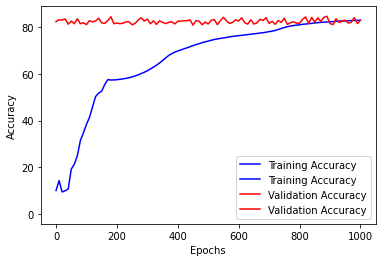

In [ ]:
plot_graph(training_accuracy, validation_accuracy, "Accuracy")

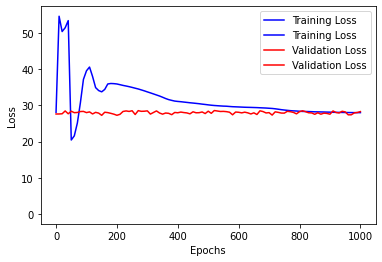

In [ ]:
plot_graph(training_loss, validation_loss, "Loss")

# MLP model pickling

In [ ]:
pickle.dump(Model_1, open('model_1.pkl', 'wb'))

In [ ]:
pickle.dump(Model_2, open('model_2.pkl', 'wb'))

In [ ]:
pickle.dump(Model_3, open('model_3.pkl', 'wb'))

In [ ]:
pickle.dump(Model_4, open('model_4.pkl', 'wb'))

## Observations:

Looking at the training accuracy plots of ReLU vs Sigmoid, we notice that the ReLU reaches close to 80% accuracy within 400 epochs while the Sigmoid version is still at < 70%. This can be explained by the fact that the gradient for ReLU activation has a constant value. In contrast, the gradient for sigmoid diminishes. The constant gradient of ReLUs results in faster learning.

The loss vs. epoch graphs show that with the Normal Weight initialization, the loss plot is somewhat smoother. Weights in this case have the same variance. With deeper neural networks, random weight initializations do not seem to work well with sigmoid activation. Hence a variety of techniques is used to improve performance.
